# Analyse des données

## Répartition des classes (Histogrammes)

In [40]:
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from collections import defaultdict
import shutil
import random
import cv2

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from sklearn.model_selection import train_test_split

In [41]:
# Extraction du dataset
def extract_dataset(zip_path, extract_to):
    """
    Extrait les fichiers d'un dataset zippé.

    Args:
        zip_path (str): Chemin vers le fichier zip.
        extract_to (str): Dossier où extraire les fichiers.
    """
    # Convertir les chemins en chemins absolus pour éviter les erreurs
    zip_path = os.path.abspath(zip_path)
    extract_to = os.path.abspath(extract_to)

    if not os.path.exists(zip_path):
        raise FileNotFoundError(f"Le fichier {zip_path} n'existe pas.")
    
    # Si le dossier de destination existe, le supprimer
    if os.path.exists(extract_to):
        shutil.rmtree(extract_to)
        print(f"Le dossier existant {extract_to} a été supprimé.")

    os.makedirs(extract_to, exist_ok=True)

    with ZipFile(zip_path, 'r') as zip_ref:
        # Aplatir la structure du zip : extraire les fichiers directement dans extract_to
        for member in zip_ref.namelist():
            filename = os.path.basename(member)
            # Vérifie si c'est un fichier zip contenant 'Livrable 1 - Photo' et 'Livrable 2' dans le nom
            if filename and filename.endswith('.zip') and any(keyword in filename for keyword in ['Livrable 1 - Photo', 'Livrable 2']):
                source = zip_ref.open(member)
                target_path = os.path.join(extract_to, filename)
                with source, open(target_path, "wb") as target:
                    target.write(source.read())
        

    # Extrait le contenu de tous les sous-zip **directement dans extract_to**
    for file in os.listdir(extract_to):
        if file.endswith('.zip'):
            sub_zip_path = os.path.join(extract_to, file)
            with ZipFile(sub_zip_path, 'r') as sub_zip_ref:
                for member in sub_zip_ref.namelist():
                    # Ne garde que le nom du fichier sans les sous-dossiers internes
                    filename = os.path.basename(member)
                    if filename:
                        source = sub_zip_ref.open(member)
                        target_file = os.path.join(extract_to, filename)
                        with source, open(target_file, "wb") as target:
                            target.write(source.read())
            os.remove(sub_zip_path)  # Supprime le zip après extraction
    
    print(f"Dataset extrait dans le dossier : {extract_to}")

def load_images(folder_path):
    """
    Charge toutes les images en mémoire et assure la cohérence des canaux.

    Args:
        folder_path (str): Chemin vers le dataset.
    """
    images = []
    valid_ext = ('.png', '.jpg', '.jpeg')

    # Convertir le chemin en chemins absolus pour éviter les erreurs
    folder_path = os.path.abspath(folder_path)

    # 1. Chargement et vérification des images
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"Dossier introuvable : {folder_path}")

    for f in os.listdir(folder_path):
        if f.lower().endswith(valid_ext):
            img = Image.open(os.path.join(folder_path, f))
            # Converti en RGB si necessaire pour assurer la coherence
            if img.mode != 'RGB':
                img = img.convert('RGB')
            images.append(np.array(img))

    if not images:
        raise ValueError("Aucune image valide trouvée")

    return images
 
def check_image_resolutions(folder):
    """
    Fonction pour obtenir les résolutions des images d'origine.

    Args:
        folder (str): Chemin vers le dataset.
    """
    # Convertir le chemin en chemin absolu pour éviter les erreurs
    folder = os.path.abspath(folder)

    resolutions = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            resolutions.append(img.shape[:2])  # (hauteur, largeur)
    return resolutions


In [42]:
# Appel de la fonction pour extraire le dataset
dataset_zip_path = './Dataset/Datasets.zip'
extract_dataset(dataset_zip_path, './Dataset/Dataset2')

Le dossier existant c:\Users\Ahmed AMARA\Desktop\A5\deeplearning\projet\Data-science-project-A5\Dataset\Dataset2 a été supprimé.
Dataset extrait dans le dossier : c:\Users\Ahmed AMARA\Desktop\A5\deeplearning\projet\Data-science-project-A5\Dataset\Dataset2


In [43]:
# Configuration
dataset_path = './Dataset/Dataset2/'
img_size = (128, 128)  # Taille de l'image
num_samples = 6 # Nombre d'échantillons à afficher
batch_size = 32  # Taille du lot pour l'entraînement
epochs = 50  # Nombre d'époques pour l'entraînement


In [ ]:
# Charger les images d'origines
images = load_images(dataset_path)

In [ ]:
# Charge les résolutions des images
resolutions = check_image_resolutions(dataset_path)
heights = [res[0] for res in resolutions]
widths = [res[1] for res in resolutions]

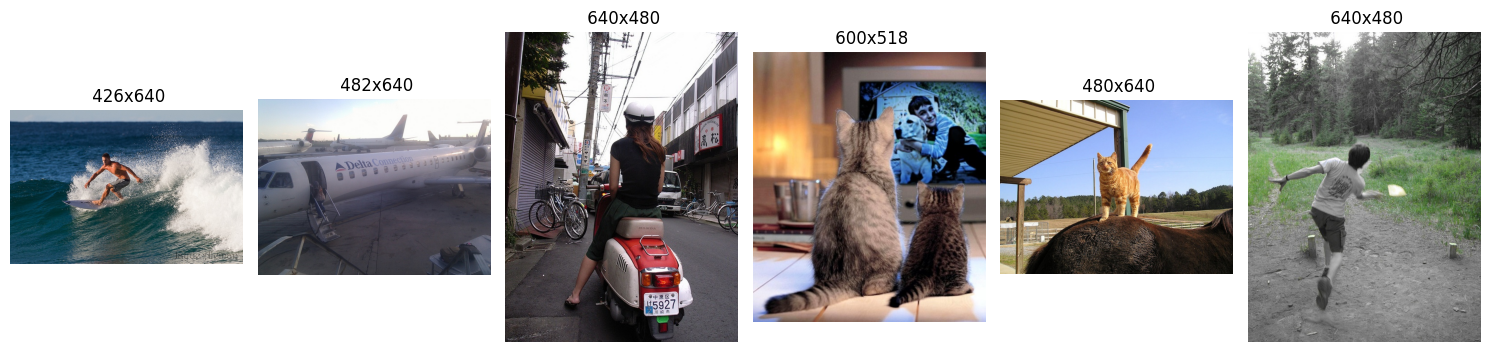

In [ ]:
# Affichage des résolutions d'origine
#print("Distribution des résolutions (hauteur, largeur) des images:")
#print(list(zip(heights, widths)))

# 3. Affichage de quelques images avec leurs résolutions d'origine
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
for i in range(min(num_samples, len(images))):  # Sélectionner quelques images au hasard pour les afficher
    axes[i].imshow(images[i])
    axes[i].set_title(f" {heights[i]}x{widths[i]}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# 4. Fonction pour Redimensionner les images
def resize_images(images, target_size=img_size):
    """Redimensionne toutes les images et les convertit en RGB"""
    resized_images = []
    for img in images:
        img_pil = Image.fromarray(img).convert('RGB')  # Forcer en RGB
        img_resized = img_pil.resize(target_size)
        resized_images.append(np.array(img_resized))
    return np.array(resized_images)



resized_images = resize_images(images, target_size=img_size)
# resized_second_images = resize_images(Second_images, target_size=img_size)
# Sauvegarder pour les prochaines utilisations
# np.save('/content/drive/My Drive/Projet/second_images.npy', resized_second_images)
# Charger directement les images sauvegardées
# second_images = np.load('/content/drive/My Drive/Projet/second_images.npy', allow_pickle=True)


## Affichage d'échantillon de data

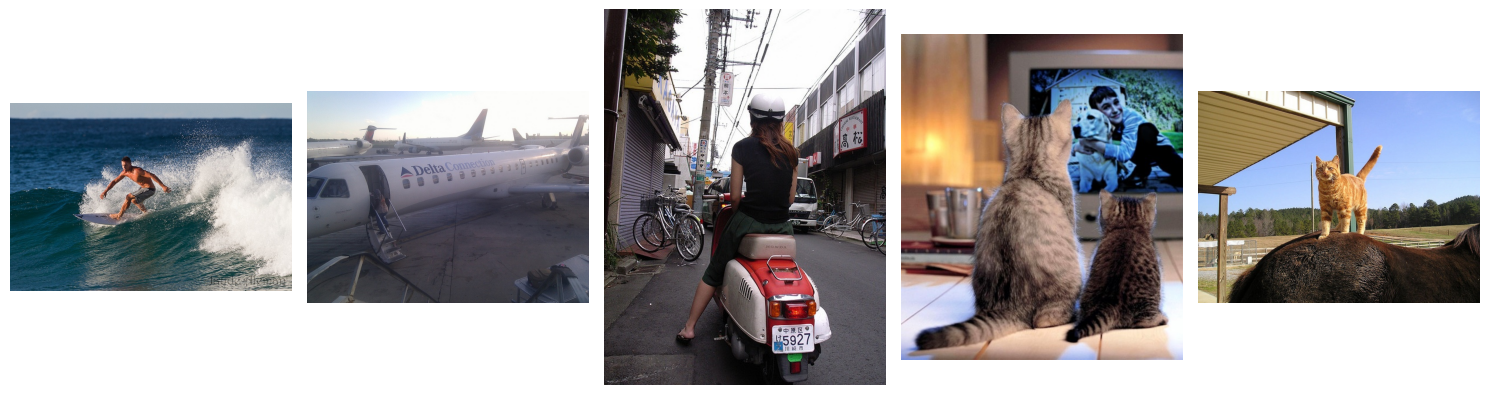

In [ ]:
from PIL import Image  # Import the Image module from PIL

# 2. Chargement et affichage d'échantillon
all_images = load_images(dataset_path)

def display_images(images, num_samples=5):
    """Affiche un échantillon d'images"""
    plt.figure(figsize=(15, 5))
    for i in range(min(num_samples, len(images))):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.tight_layout()  # Ajout pour éviter le chevauchement
    plt.show()

# Appel de la fonction
display_images(all_images)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_image_statistics(all_images, max_images=2000):
    """
    Calcule la moyenne, l'écart type et la médiane des pixels sur un sous-ensemble des images.
    """
    print("Calcul des statistiques d'image...")

    # Échantillonnage si trop d'images
    if len(all_images) > max_images:
        print(f"⚠️ Trop d'images ({len(all_images)}). Utilisation d'un échantillon de {max_images} images.")
        sampled_images = all_images[:max_images]
    else:
        sampled_images = all_images

    # Aplatir les pixels des images (optimisé avec float32)
    pixel_values = np.concatenate([img.astype(np.float32).ravel() for img in sampled_images])

    mean = np.mean(pixel_values)
    std = np.std(pixel_values)
    median = np.median(pixel_values)

    return mean, std, median, pixel_values


def plot_color_distribution(all_images, max_images=2000):
    """
    Affiche la distribution des couleurs (R, G, B) sur un sous-ensemble des images.
    """
    print("Analyse de la distribution des couleurs...")

    if len(all_images) > max_images:
        print(f"⚠️ Trop d'images ({len(all_images)}). Utilisation d'un échantillon de {max_images} images.")
        sampled_images = all_images[:max_images]
    else:
        sampled_images = all_images

    reds, greens, blues = [], [], []

    for img in sampled_images:
        if img.ndim == 3 and img.shape[-1] == 3:
            reds.append(img[:, :, 2].ravel())
            greens.append(img[:, :, 1].ravel())
            blues.append(img[:, :, 0].ravel())

    reds = np.concatenate(reds).astype(np.float32)
    greens = np.concatenate(greens).astype(np.float32)
    blues = np.concatenate(blues).astype(np.float32)

    plt.figure(figsize=(10, 5))
    plt.hist(reds, bins=50, color='red', alpha=0.5, label='Rouge')
    plt.hist(greens, bins=50, color='green', alpha=0.5, label='Vert')
    plt.hist(blues, bins=50, color='blue', alpha=0.5, label='Bleu')
    plt.title("Distribution des couleurs des images")
    plt.xlabel("Valeur des pixels (0-255 ou normalisé)")
    plt.ylabel("Nombre de pixels")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
mean, std, median, pixel_values = calculate_image_statistics(all_images)
print(f"Moyenne : {mean}")
print(f"Écart type : {std}")
print(f"Médiane : {median}")

plot_color_distribution(all_images)

Calcul des statistiques d'image...
⚠️ Trop d'images (10141). Utilisation d'un échantillon de 2000 images.


MemoryError: Unable to allocate 3.16 MiB for an array with shape (431, 640, 3) and data type float32

In [ ]:
plot_color_distribution(all_images)

## Data Augmentation

In [ ]:
# Nouvelle fonction de data augmentation
def augment_images(images, augment_factor=2): # Augmente le nombre d'images
    """Génère des images augmentées"""
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='reflect' #Les bords sont remplis par effet miroir : les valeurs de pixels sont copiées en sens inversé
   )

    augmented_images = []
    for img in images:
        img = img.reshape((1,) + img.shape)
        for _ in range(augment_factor):
            for batch in datagen.flow(img, batch_size=1):
                augmented_images.append(batch[0])
                break
    return np.array(augmented_images)

# Application avant le split
print("Augmentation des données...")
augmented_images = augment_images(all_images)
all_images = np.concatenate([all_images, augmented_images])
print(f"Nouveau nombre total d'images: {len(all_images)}")

Augmentation des données...
Nouveau nombre total d'images: 592


In [ ]:
def preprocess_data(images):
    """Normalisation et redimensionnement"""
    images = images.astype('float32') / 255.  # Normalisation
    return images

# Split train/test
x_train, x_test = train_test_split(all_images, test_size=0.2, random_state=42)

# Application du prétraitement
x_train = preprocess_data(x_train)
x_test = preprocess_data(x_test)

print(f"\nForme des données :")
print(f"Train: {x_train.shape} (ex: {x_train[0].shape})")
print(f"Nombre d'images d'entrainement : {len(x_train) }")
print(f"Test: {x_test.shape} (ex: {x_test[0].shape})")
print(f"Nombre d'images test : {len(x_test) }")


Forme des données :
Train: (473, 256, 256, 3) (ex: (256, 256, 3))
Nombre d'images d'entrainement : 473
Test: (119, 256, 256, 3) (ex: (256, 256, 3))
Nombre d'images test : 119


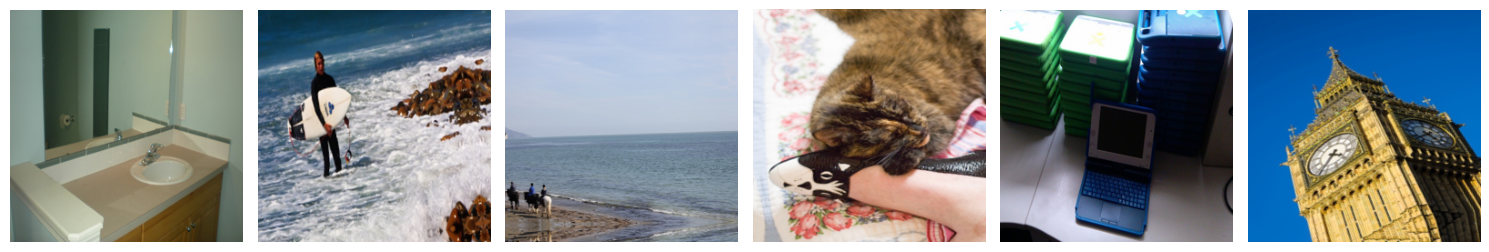

In [ ]:
display_images(x_train, num_samples=6)  

## Auto-encodeur de réduction de bruit (denoiser)

In [ ]:

def add_noise(images, noise_type="gaussian", noise_factor=0.3):
    noisy_images = images.copy()

    # if noise_type == "gaussian":
    #     noise = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    #     noisy_images += noise

    # elif noise_type == "poisson":
    #     noise = np.random.poisson(images * 255.0) / 255.0  # Convert to 0-1 range
    #     noisy_images += noise

    # if noise_type == "speckle":
    #     noise = noise_factor * np.random.randn(*images.shape)
    #     noisy_images += images * noise

    if noise_type == "salt_pepper":
        prob = noise_factor / 2
        rnd = np.random.rand(*images.shape)
        noisy_images[rnd < prob] = 0  # Sel (noir)
        noisy_images[rnd > (1 - prob)] = 1  # Poivre (blanc)

    return np.clip(noisy_images, 0., 1.)

# Appliquer plusieurs types de bruits
# x_train_noisy_gaussian = add_noise(x_train, "gaussian")
# x_test_noisy_gaussian = add_noise(x_test, "gaussian")

# x_train_noisy_speckle = add_noise(x_train, "speckle")
# x_test_noisy_speckle = add_noise(x_test, "speckle")

x_train_noisy_sp = add_noise(x_train, "salt_pepper")
x_test_noisy_sp = add_noise(x_test, "salt_pepper")

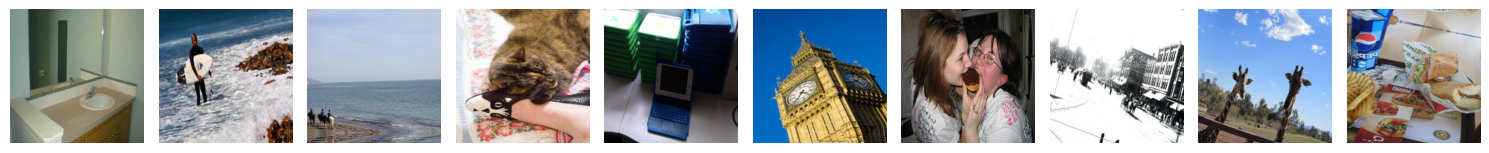

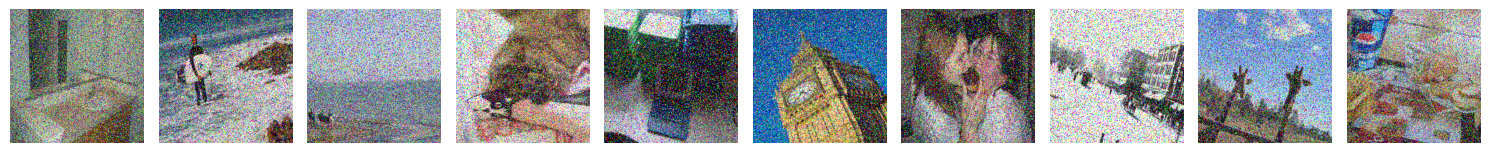

In [ ]:
display_images(x_train, num_samples=10) 
# display_images(x_train_noisy_gaussian, num_samples=10) 
# display_images(x_train_noisy_speckle, num_samples=10) 
display_images(x_train_noisy_sp, num_samples=10) 



In [ ]:
print("Dimensions des données :")
print("x_test shape:", x_test.shape)          # Doit être (N, 256, 256, 3)


Dimensions des données :
x_test shape: (119, 256, 256, 3)


In [ ]:
# Configurations principales de nos modèles
IMG_SIZE          = img_size                # taille coté final d'une image en pixel (ici 28x28)
NB_EPOCHS_DENOISE = 50               # nombre epoch alogithme debruiter
BATCH_SIZE        = 32               # taille batch de traitement
SAV_MODEL_DENOISE = "denoiser2.h5"     # sauvegarde du modele de debruitage

## Encodeur

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Input, Flatten, Dense, Reshape, regularizers

input_img = Input(shape=(256, 256, 3))

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)  # 128x128

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)  # 64x64

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)  # 32x32

# Passage à une couche dense
x = Flatten()(x)  # (32*32*256,) = (262144,)
x = Dense(
    1024, 
    activation='relu', 
    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
)(x)  
x = Dense(32*32*256, activation='relu')(x)
x = Reshape((32, 32, 256))(x)

## Decodeur

In [ ]:
from tensorflow.keras.layers import UpSampling2D, Dropout, Conv2D, BatchNormalization

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)  # 64x64

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)  # 128x128

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)  # 256x256

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)



In [ ]:
from tensorflow.keras.models import Model

autoencoder = Model(input_img, decoded)
from tensorflow.keras.optimizers import Adam

autoencoder.compile(optimizer=Adam(learning_rate=0.010), loss='mse')  # MSE au lieu de binary_crossentropy pour les images continues

autoencoder.compile(optimizer=Adam(learning_rate=0.010), loss='mse')  # MSE au lieu de binary_crossentropy pour les images continues
autoencoder.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 256, 256, 3)    │         1,73

 Total params: 1,335,043 (5.09 MB)

 Trainable params: 1,333,251 (5.09 MB)

 Non-trainable params: 1,792 (7.00 KB)

## visualisation auto-encodeur

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(autoencoder, to_file='autoencoder_architecture.png', show_shapes=True, show_layer_names=True)


## Entrainement

In [ ]:
%reload_ext tensorboard

In [ ]:

# history = autoencoder.fit(
    # x_train_noisy_gaussian, x_train,
    # epochs=50,
    # batch_size=64,
    # shuffle=True,
    # validation_data=(x_test_noisy_gaussian, x_test)
# )

# history_speckle = autoencoder.fit(
#     x_train_noisy_speckle, x_train,
#     epochs=50,
#     batch_size=64,
#     shuffle=True,
#     validation_data=(x_test_noisy_speckle, x_test)
# )

history_sp = autoencoder.fit(
    x_train_noisy_sp, x_train,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_data=(x_test_noisy_sp, x_test)
)


Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 120s 8s/step - loss: 0.1053 - val_loss: 0.3695
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 111s 7s/step - loss: 0.0233 - val_loss: 0.3694
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 110s 7s/step - loss: 0.0201 - val_loss: 0.3489
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 112s 7s/step - loss: 0.0189 - val_loss: 0.2569
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 114s 8s/step - loss: 0.0180 - val_loss: 0.1339
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 136s 7s/step - loss: 0.0158 - val_loss: 0.0463
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 109s 7s/step - loss: 0.0141 - val_loss: 0.0500
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 108s 7s/step - loss: 0.0136 - val_loss: 0.0366
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 108s 7s/step - loss: 0.0133 - val_loss: 0.0286
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 110s 7s/step - loss: 0.0124 - val_loss: 0.0253
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 113s 7s/step - loss: 0.0134 - val_loss: 0.0401
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 103s 7s/step - loss: 0.0

C:\Users\Ahmed AMARA\AppData\Local\Temp\ipykernel_9332\4003077027.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


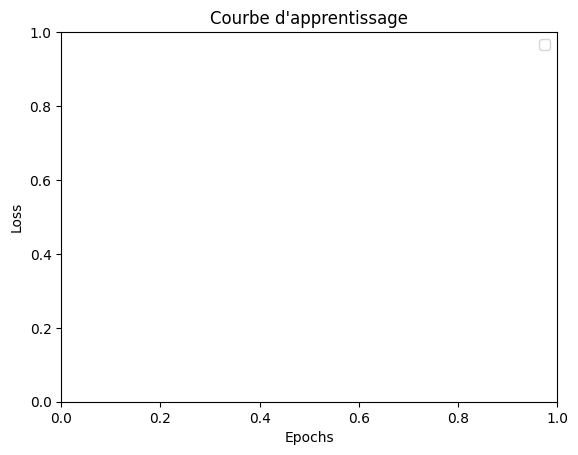

<Figure size 1000x500 with 0 Axes>

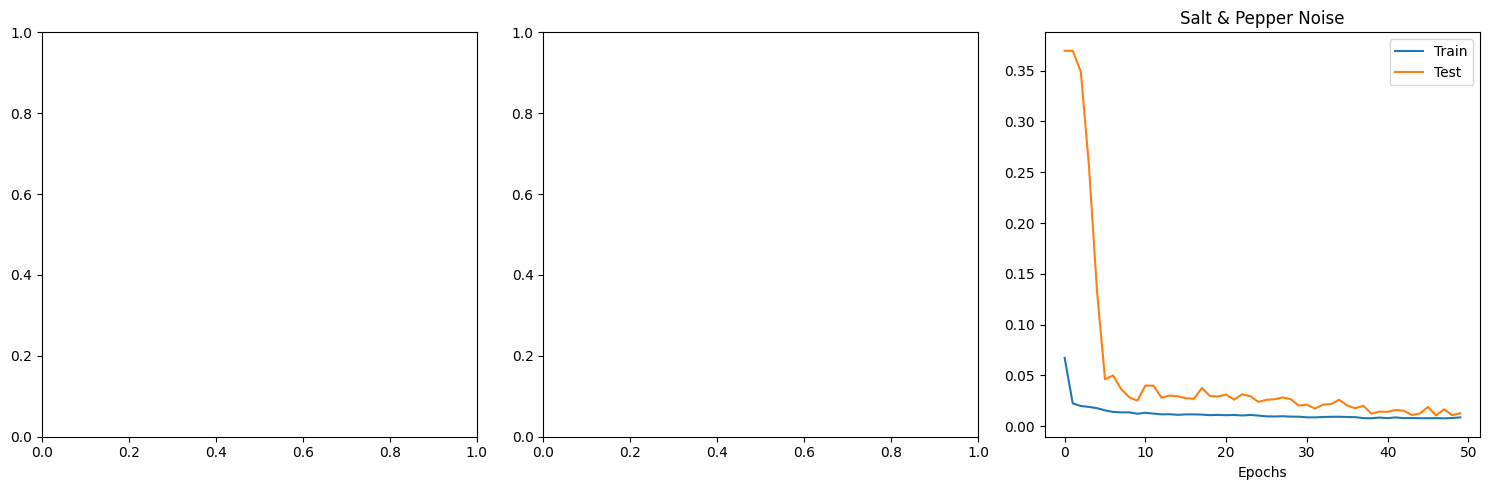

In [ ]:
# Visualisation des pertes d'apprentissage (Train) et de validation (Test)
# plt.plot(history.history['loss'], label='train')  # Pertes d'apprentissage
# plt.plot(history.history['val_loss'], label='test')  # Pertes de validation
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Courbe d\'apprentissage')
plt.show()
plt.figure(figsize=(10, 5))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Gaussian Noise
# axes[0].plot(history.history['loss'], label='Train')
# axes[0].plot(history.history['val_loss'], label='Test')
# axes[0].set_title("Gaussian Noise")
# axes[0].set_xlabel('Epochs')
# axes[0].set_ylabel('Loss')
# axes[0].legend()

# # Speckle Noise
# axes[1].plot(history_speckle.history['loss'], label='Train')
# axes[1].plot(history_speckle.history['val_loss'], label='Test')
# axes[1].set_title("Speckle Noise")
# axes[1].set_xlabel('Epochs')
# axes[1].legend()

# Salt & Pepper Noise
axes[2].plot(history_sp.history['loss'], label='Train')
axes[2].plot(history_sp.history['val_loss'], label='Test')
axes[2].set_title("Salt & Pepper Noise")
axes[2].set_xlabel('Epochs')
axes[2].legend()

plt.tight_layout()
plt.show()


In [ ]:
# autoencoder.save(SAV_MODEL_DENOISE)  # Sauvegarde du modèle

In [ ]:
print("Dimensions des données :")
print("x_test shape:", x_test.shape)          # Doit être (N, 256, 256, 3)

print("Modèle input shape:", autoencoder.input_shape)  # Doit être (None, 256, 256, 3)

Dimensions des données :
x_test shape: (119, 256, 256, 3)
Modèle input shape: (None, 256, 256, 3)


In [ ]:
import numpy as np

def psnr(original, compressed):
    """Calculates the Peak Signal-to-Noise Ratio (PSNR) between two images."""
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:  # No noise
        return float('inf')
    max_pixel = 1.0  # Assuming the pixel values are normalized between 0 and 1
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr_value

def visualize_denoising(model, clean_images, noisy_images, num_samples=3):
    """Version corrigée avec affichage garanti"""
    # 1. Vérification des entrées
    num_samples = min(num_samples, len(clean_images))
    print(f"\nVisualisation de {num_samples} échantillons...")
    
    # 2. Prédiction
    try:
        denoised = model.predict(noisy_images[:num_samples], verbose=0)
        print("Prédiction réussie. Shapes :")
        print(f"- Original : {clean_images[0].shape}")
        print(f"- Bruité : {noisy_images[0].shape}")
        print(f"- Débruité : {denoised[0].shape}")
    except Exception as e:
        print("\nÉchec de prédiction :")
        print(f"Erreur : {str(e)}")
        print("Vérifiez que :")
        print("- Le modèle est compilé")
        print("- noisy_images.shape =", noisy_images.shape)
        print("- model.input_shape =", model.input_shape)
        return

    # 3. Configuration du plot
    plt.figure(figsize=(15, 8), dpi=100)  # Augmentation de la résolution
    
    # 4. Affichage des images
    for i in range(num_samples):
        # Calcul des métriques
        try:
            psnr_n = psnr(clean_images[i], noisy_images[i])
            psnr_d = psnr(clean_images[i], denoised[i])
        except:
            psnr_n = psnr_d = float('nan')  # En cas d'échec du calcul
        
        # Original
        plt.subplot(3, num_samples, i+1)
        plt.imshow(clean_images[i].squeeze(), cmap='gray' if clean_images[i].shape[-1] == 1 else None)
        plt.title(f"Original\nPSNR: ∞ dB", fontsize=8)
        plt.axis('off')
        
        # Bruité
        plt.subplot(3, num_samples, i+1+num_samples)
        plt.imshow(noisy_images[i].squeeze(), cmap='gray' if noisy_images[i].shape[-1] == 1 else None)
        plt.title(f"Noisy\nPSNR: {psnr_n:.2f} dB", fontsize=8)
        plt.axis('off')
        
        # Débruité
        plt.subplot(3, num_samples, i+1+2*num_samples)
        plt.imshow(denoised[i].squeeze(), cmap='gray' if denoised[i].shape[-1] == 1 else None)
        plt.title(f"Denoised\nPSNR: {psnr_d:.2f} dB", fontsize=8)
        plt.axis('off')

    # 5. Affichage final
    plt.tight_layout()
    plt.show()
    print("Visualisation terminée!")


In [ ]:
print("Dimensions des données :")
print("x_test shape:", x_test.shape)          # Doit être (N, 256, 256, 3)
# print("x_test_noisy shape:", x_test_noisy_gaussian.shape)  # Doit être (N, 256, 256, 3)
print("x_test_noisy shape:", x_test_noisy_sp.shape)  # Doit être (N, 256, 256, 3)
# print("x_test_noisy shape:", x_train_noisy_speckle.shape)  # Doit être (N, 256, 256, 3)

print("Modèle input shape:", autoencoder.input_shape)  # Doit être (None, 256, 256, 3)

Dimensions des données :
x_test shape: (119, 256, 256, 3)
x_test_noisy shape: (119, 256, 256, 3)
Modèle input shape: (None, 256, 256, 3)


x_test_noisy shape: (119, 256, 256, 3)

Visualisation de 3 échantillons...
Prédiction réussie. Shapes :
- Original : (256, 256, 3)
- Bruité : (256, 256, 3)
- Débruité : (256, 256, 3)


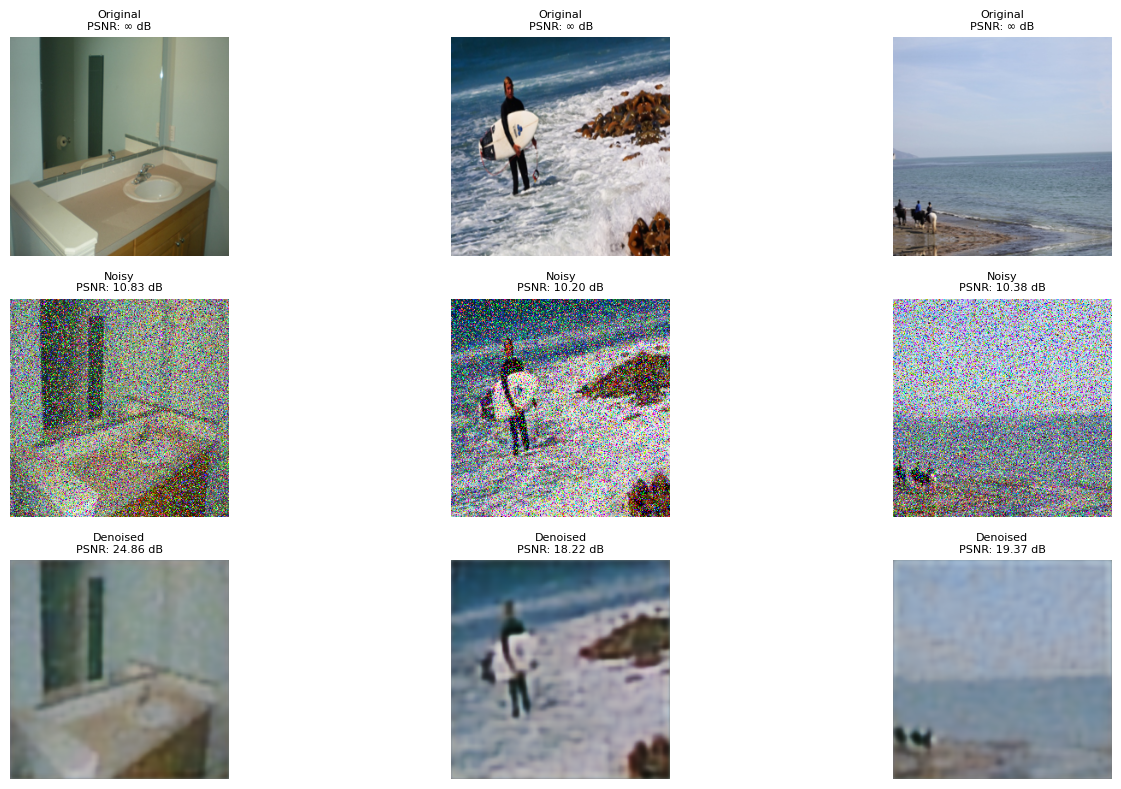

Visualisation terminée!


In [ ]:
# # Test minimal
# print("=== Test de visualisation ===")
# print("x_test shape:", x_test.shape)          # Doit être (N, 256, 256, 3)
# # print("x_test_noisy shape:", x_test_noisy_gaussian.shape)  # Doit être (N, 256, 256, 3)
print("x_test_noisy shape:", x_test_noisy_sp.shape)  # Doit être (N, 256, 256, 3)
# visualize_denoising(autoencoder, x_test[:3], x_train_noisy_speckle[:3])  # Test avec 3 échantillons
visualize_denoising(autoencoder, x_test[:3], x_train_noisy_sp[:4])  # Test avec 3 échantillons